## Churchland Widefield Data

This notebook demonstrates:
- Plot PCA latents and PCA latent trajectory for left vs right
- Plot PCA latents and PCA latent trajectory for reward vs non-reward
- Check out trajectories using SLDS
This is done in the representative mSM30 mouse, for the 10-Oct-2017 session. This is a sanity check, performed on the period around the presentation of the spout

In [1]:
import numpy as np
import pandas as pd
import ssm
import seaborn as sns
import numpy.random as npr
import matplotlib.pyplot as plt
import numpy.linalg as la
from collections import OrderedDict
from matplotlib.font_manager import FontProperties
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from ssm import LDS
from Session import *
from LVM import *
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import matplotlib
import matplotlib.pyplot as plt

import ssm
from ssm.util import find_permutation

sns.set_style("white")
sns.set_context("talk")

# Load Data and Set Parameters

In [2]:
session = Session("vistrained", "mSM30", "10-Oct-2017")
all_neural_data = session.neural['neural']
all_neural_data = all_neural_data[5:45,:,:]
concat_data, concat_data_test = train_test_split(all_neural_data, test_size=0.5)
concat_data = concat_data.reshape((-1,session.num_components))
concat_data_test = concat_data_test.reshape((-1,session.num_components))

In [3]:
# HMM parameters
T = concat_data.shape[0] # Number of time bins
K = 0 # Number of discrete states (to be cross-validated)
D = concat_data.shape[1] # Number of observed dimensions

# Fit ARHMM for different values of $k$

In [4]:
# Fit with both SGD and EM
methods = ["em"]
N_em_iters = 100
obs = "ar" #Autoregressive HMM

def fit_hmm(K):
    results = {}
    for method in methods:
        model = ssm.HMM(K, D, observations=obs)
        train_lls = model.fit(concat_data, method=method)
        test_ll = model.log_likelihood(concat_data_test)
        smoothed_y = model.smooth(concat_data)

        # Permute to match the true states
        smoothed_z = model.most_likely_states(concat_data)
        results[(obs, method)] = (model, train_lls, test_ll, smoothed_z, smoothed_y)
    return results

In [5]:
K_results = []
for K in range(4,10,2):
    results = fit_hmm(K)
    K_results.append(results)

# Check the log likelihood evolution over time

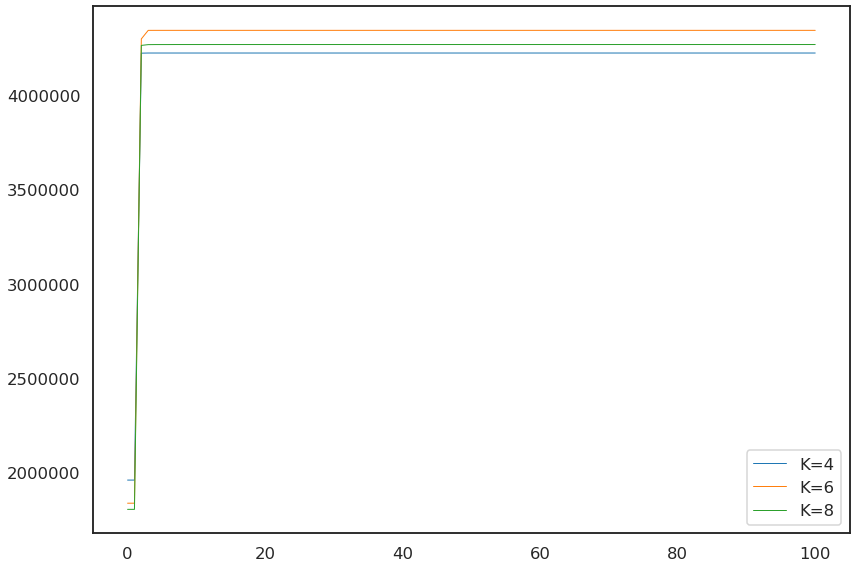

In [9]:
# Plot log likelihoods
plt.figure(figsize=(12, 8))
method = methods[0]
idx = 0
for K in range(4, 10, 2):
    results = K_results[idx]
    line = None
    _, lls, _, _, _ = results[(obs, method)]
    color = line.get_color() if line is not None else None
    line = plt.plot(lls, lw=1, color=color, label="K=%d"%K)[0]
    idx += 1

xlim = plt.xlim()
plt.xlim(xlim)
plt.legend(loc="lower right")
plt.tight_layout()

# Choose best $K$

In [15]:
# Choosing the correct K
# Print the test log likelihoods
i = 0
for K in range(4, 10, 2):
    print("K = " + str(K))
    print("Test log likelihood")
    results = K_results[i]
    _, _, test_ll, _, _ = results[(obs, method)]
    print("{} ({}): {}".format(obs, method, test_ll))
    print()
    i += 1

K = 4
Test log likelihood
ar (em): 4084188.3026876114

K = 6
Test log likelihood
ar (em): 4047003.4508278407

K = 8
Test log likelihood
ar (em): 4027983.67555143



# Check out inferred states

In [16]:
session = Session("vistrained", "mSM30", "10-Oct-2017")
delay_period_indices = session.get_delay_period()
min_delay_size = np.min([x[1]-x[0] for x in delay_period_indices])

Text(0.5, 0.98, 'Inferred Discrete States')

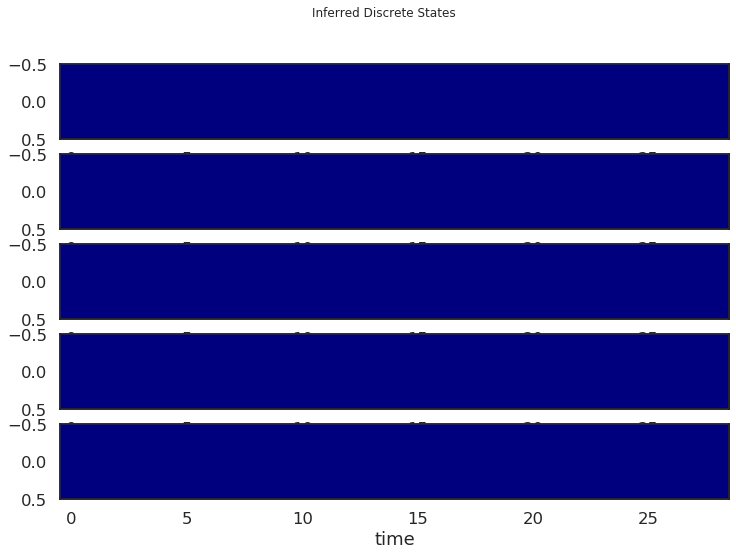

In [21]:
best_K_idx = 0
results = K_results[best_K_idx]
method = methods[0]

# Plotting inferred states
fig, axs = plt.subplots(
    nrows=5, ncols=1, figsize=(12, 8)
    )

# Plot the inferred states
_, _, _, smoothed_z, _ = results[(obs, method)]
for i in range(axs.size): # Extract trial by trial
    ax = axs[i]
    delay_start = delay_period_indices[i,:][0]
    trial_z = smoothed_z[i*189:(i+1)*189]
    trial_z_delay = trial_z[delay_start:delay_start+min_delay_size]
    trial_z_delay = np.expand_dims(trial_z_delay, axis=0)
    plt.sca(ax)
    plt.imshow(trial_z_delay, aspect="auto", cmap="jet")
    plt.xlabel("time")
plt.suptitle("Inferred Discrete States")